## Emotion Prediction on GoEmotion Dataset

### Package Install and Import Data

In [ ]:
#!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio
!pip install jsonlines
!pip install transformers
!pip install tqdm scikit-learn datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


In [ ]:
import torch
print(torch.__version__)
import jsonlines
import numpy as np
import transformers
import pandas as pd
import pickle as pkl
from torch import nn
from tqdm import tqdm
from os.path import join
import multiprocessing as mp
from importlib import reload
from collections import Counter
from datasets import load_dataset
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from transformers import (WEIGHTS_NAME,
                          BertConfig, BertForSequenceClassification, BertTokenizer,
                          XLMConfig, XLMForSequenceClassification, XLMTokenizer,
                          DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import BertPreTrainedModel, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel

2.1.0+cu118


### Load and Prepare Data

In [ ]:
class emotionDataset(Dataset):
    """Class to load the dataset and get batches of paras"""

    def __init__(self, list_data,
                 tokenizer, max_length):

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = list_data
        self.pad_token = 1

    def __len__(self):
        """Return length of dataset."""
        return self.data.__len__()

    def __getitem__(self, i):
        """Return sample from dataset at index i."""
        example = self.data[i]
        inputs = self.tokenizer.encode_plus(example['text'],
                                            add_special_tokens=True,
                                            truncation=True,
                                            max_length=self.max_length)

        input_ids = inputs["input_ids"]
        input_ids = input_ids[:self.max_length]
        attention_mask = [1] * len(input_ids)

        padding_length = self.max_length - len(input_ids)
        input_ids = input_ids + ([self.pad_token] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)

        assert len(input_ids) == self.max_length, "Error with input length {} vs {}".format(len(input_ids), self.max_length)

        nli_label = example['labels'][0]

        return_dict = {'input_ids':torch.LongTensor(input_ids),
                       'attention_mask':torch.LongTensor(attention_mask),
                       'labels': torch.LongTensor([nli_label])}

        return return_dict

In [ ]:
id2label = {0:"admiration",
            1:"amusement",
            2:"anger",
            3:"annoyance",
            4:"approval",
            5:"caring",
            6:"confusion",
            7:"curiosity",
            8:"desire",
            9:"disappointment",
            10:"disapproval",
            11:"disgust",
            12:"embarrassment",
            13:"excitement",
            14:"fear",
            15:"gratitude",
            16:"grief",
            17:"joy",
            18:"love",
            19:"nervousness",
            20:"optimism",
            21:"pride",
            22:"realization",
            23:"relief",
            24:"remorse",
            25:"sadness",
            26:"surprise",
            27:"neutral"}

In [ ]:
dataset = load_dataset("go_emotions", "simplified")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
# @title look into dataset
print(Counter([x['labels'].__len__() for x in dataset['train']]))
print(dataset.keys())
print(dataset['train'][0])

Counter({1: 36308, 2: 6541, 3: 532, 4: 28, 5: 1})
dict_keys(['train', 'validation', 'test'])
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


In [ ]:
# @title set config
roberta_config = RobertaConfig.from_pretrained('roberta-base',
                                      num_labels=len(id2label),
                                      finetuning_task='GoEmotions',
                                      cache_dir=None,
                                      output_attentions=False,
                                      output_hidden_states=False)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)

In [ ]:
# @title tried different batch size 16, 32...
# Train dataset
train_dataset = emotionDataset(list_data=dataset['train'],
                               tokenizer=tokenizer,
                               max_length=200)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=mp.cpu_count())

# Validation dataset
val_dataset = emotionDataset(list_data=dataset['validation'],
                             tokenizer=tokenizer,
                             max_length=200)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                        num_workers=mp.cpu_count())

# Test dataset
test_dataset = emotionDataset(list_data=dataset['test'],
                               tokenizer=tokenizer,
                               max_length=200)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False, num_workers=mp.cpu_count())

In [ ]:
# @title batch
example_batch = next(iter(train_loader))
example_batch['input_ids'].shape, example_batch['attention_mask'].shape, example_batch['labels'].shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([32, 1]))

### Train Model

In [ ]:
model = RobertaForSequenceClassification(config=roberta_config).cuda()

In [ ]:
# @title tried different learning rate 1e-5, 2e-5
args = {'weight_decay':0.0,
        'learning_rate':2e-5,
        'epochs':5,
        'gradient_accumulation_steps':1,
        'adam_epsilon':1e-8}
args['t_total'] = len(train_loader) // args['gradient_accumulation_steps'] * args['epochs']
args['warmup_steps'] = int(0.10*args['t_total'])

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'],
                                            num_training_steps=args['t_total'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model = nn.DataParallel(model.cuda())

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/NLP/Project3/Checkpoints/'  # Replace with your desired path
os.makedirs(model_save_path, exist_ok=True)


Mounted at /content/drive


In [ ]:
# Modify the Training Loop to Include Validation

for each_epoch in range(args['epochs']):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        model.zero_grad()
        outputs = model(**batch)
        loss = outputs[0].mean()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(**batch)
            loss = outputs[0].mean()
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {each_epoch + 1}/{args['epochs']} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # Save model after each epoch
    epoch_save_path = os.path.join(model_save_path, f'model_epoch_{each_epoch+1}.pt')
    torch.save(model.state_dict(), epoch_save_path)
    print(f"Saved model checkpoint to {epoch_save_path}")
# model.train()
# for each_epoch in range(args['epochs']):
#     for batch in tqdm(train_loader):
#         model.zero_grad()
#         outputs = model(**batch)
#         ### Loss calculation
#         loss = outputs[0].mean()
#
#         loss.backward()
#         optimizer.step()
#         scheduler.step()  # Update learning rate schedule

100%|██████████| 1357/1357 [22:06<00:00,  1.02it/s]


Epoch 1/5 - Train Loss: 2.5239, Val Loss: 2.0100
Saved model checkpoint to /content/drive/MyDrive/NLP/Project3/Checkpoints/model_epoch_1.pt


100%|██████████| 1357/1357 [22:10<00:00,  1.02it/s]


Epoch 2/5 - Train Loss: 1.9117, Val Loss: 1.7680
Saved model checkpoint to /content/drive/MyDrive/NLP/Project3/Checkpoints/model_epoch_2.pt


100%|██████████| 1357/1357 [22:10<00:00,  1.02it/s]


Epoch 3/5 - Train Loss: 1.6414, Val Loss: 1.6773
Saved model checkpoint to /content/drive/MyDrive/NLP/Project3/Checkpoints/model_epoch_3.pt


100%|██████████| 1357/1357 [22:10<00:00,  1.02it/s]


Epoch 4/5 - Train Loss: 1.4485, Val Loss: 1.6866
Saved model checkpoint to /content/drive/MyDrive/NLP/Project3/Checkpoints/model_epoch_4.pt


100%|██████████| 1357/1357 [22:10<00:00,  1.02it/s]


Epoch 5/5 - Train Loss: 1.3080, Val Loss: 1.6857
Saved model checkpoint to /content/drive/MyDrive/NLP/Project3/Checkpoints/model_epoch_5.pt


### Loss per epoch

Epoch 1 - Train Loss: 2.5239, Val Loss: 2.0100  
Epoch 2 - Train Loss: 1.9117, Val Loss: 1.7680  
Epoch 3 - Train Loss: 1.6414, Val Loss: 1.6773  
Epoch 4 - Train Loss: 1.4485, Val Loss: 1.6866  
Epoch 5 - Train Loss: 1.3080, Val Loss: 1.6857  

This summary shows the loss values for each epoch during the training and validation phases. The decreasing trend in the training loss indicates that the model is learning effectively. However, the validation loss's slight increase in the later epochs might suggest the beginning of overfitting.

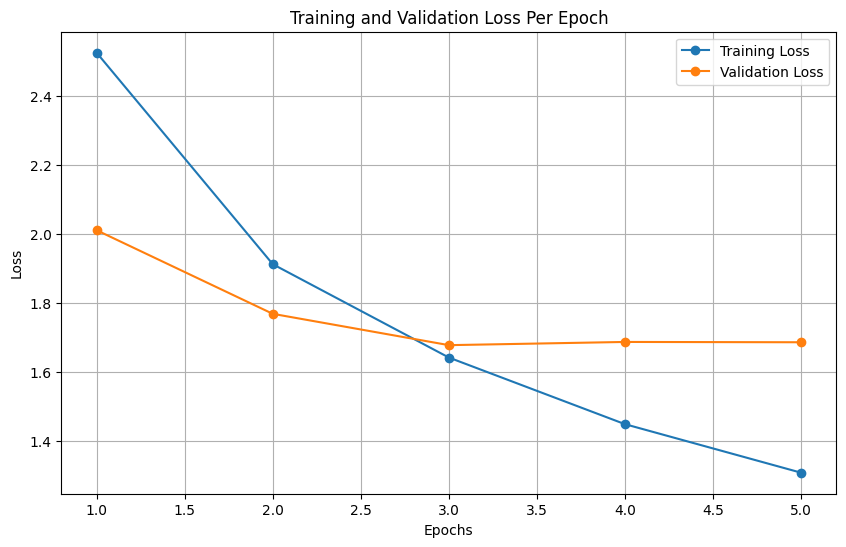

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3, 4, 5]

# Training and validation losses
train_losses = [2.5239, 1.9117, 1.6414, 1.4485, 1.3080]
val_losses = [2.0100, 1.7680, 1.6773, 1.6866, 1.6857]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

# Adding titles and labels
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Test Model Performance on test data

In [ ]:
# @title load model
import os
from google.colab import drive
drive.mount('/content/drive')
from transformers import RobertaModel, RobertaConfig
# Make sure to replace 'path_to_model' with the actual path to your .pt file
model_path = '/content/drive/MyDrive/NLP/Project3/Checkpoints/model_epoch_5.pt'

# Initialize the model architecture (make sure this matches the architecture used during training)
# For instance, if you used a specific configuration or a model for a specific task like RobertaForSequenceClassification,
# you should initialize that specific model with the same configuration.
loaded_model = RobertaForSequenceClassification(config=roberta_config).cuda()
loaded_model = nn.DataParallel(loaded_model.cuda())

# Load the state dictionary
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Apply the state dictionary to the model
loaded_model.load_state_dict(state_dict)


# test on test data
# dict_test_results_tested = evaluate(model_=loaded_model,
#                              eval_loader=test_loader)
# df_test_tested = get_performance(actual_og=dict_test_results_tested['actual'],
#                           preds_og=dict_test_results_tested['preds'],
#                           dict_mapping=id2label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [ ]:
model = loaded_model

In [ ]:
def evaluate(model_, eval_loader):
    model.eval()
    dict_result = {'actual':[],
                   'preds':[]}
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            outputs = model(**batch)
            logits = outputs[1]

            dict_result['actual'] += batch['labels'].numpy().tolist()
            dict_result['preds'] += np.argmax(logits.detach().cpu().numpy(), axis=1).tolist()
    return dict_result

In [ ]:
dict_test_results = evaluate(model_=model,
                             eval_loader=test_loader)

100%|██████████| 170/170 [00:55<00:00,  3.06it/s]


### Evaluate Model

In [ ]:
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm

def get_performance(actual_og, preds_og, dict_mapping, avoid_labels=[]):
    actual_og = [x[0] for x in actual_og]
    actual_ = []
    preds_ = []

    # Filter out specified labels
    for ind in tqdm(range(len(actual_og))):
        if actual_og[ind] not in avoid_labels and preds_og[ind] not in avoid_labels:
            actual_.append(actual_og[ind])
            preds_.append(preds_og[ind])

    # Get unique labels present after filtering
    unique_labels = sorted(set(actual_ + preds_))

    # Create target_names for only the present labels
    target_names = [dict_mapping[label] for label in unique_labels if label in dict_mapping]

    # Generate classification report
    print()
    df_report = classification_report(actual_, preds_, labels=unique_labels, target_names=target_names, output_dict=False)
    print(df_report)

    # Print additional stats
    print('--'*20)
    print('STATS')
    print('--'*20)
    print('Actual counter:', Counter(actual_))
    print('Prediction counter:', Counter(preds_))
    print('Mapping:', dict_mapping)

    return df_report


In [ ]:
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label)

100%|██████████| 5427/5427 [00:00<00:00, 1794158.41it/s]


                precision    recall  f1-score   support

    admiration       0.59      0.63      0.61       504
     amusement       0.71      0.88      0.79       252
         anger       0.44      0.42      0.43       197
     annoyance       0.32      0.17      0.22       286
      approval       0.37      0.24      0.29       318
        caring       0.32      0.23      0.27       114
     confusion       0.31      0.24      0.27       139
     curiosity       0.45      0.48      0.46       233
        desire       0.50      0.36      0.42        74
disappointment       0.27      0.13      0.17       127
   disapproval       0.26      0.19      0.22       220
       disgust       0.47      0.40      0.44        84
 embarrassment       0.50      0.13      0.21        30
    excitement       0.42      0.36      0.39        84
          fear       0.53      0.66      0.59        74
     gratitude       0.81      0.84      0.83       288
         grief       0.00      0.00      0.00 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label,
                          avoid_labels=[12, 16, 19, 21, 23, 24])

100%|██████████| 5427/5427 [00:00<00:00, 1677536.13it/s]


                precision    recall  f1-score   support

    admiration       0.59      0.63      0.61       504
     amusement       0.72      0.88      0.79       252
         anger       0.44      0.42      0.43       196
     annoyance       0.34      0.17      0.22       284
      approval       0.38      0.24      0.29       316
        caring       0.33      0.23      0.27       113
     confusion       0.31      0.25      0.28       137
     curiosity       0.45      0.48      0.46       231
        desire       0.51      0.37      0.43        73
disappointment       0.28      0.13      0.17       126
   disapproval       0.26      0.19      0.22       217
       disgust       0.50      0.40      0.45        84
    excitement       0.42      0.36      0.39        84
          fear       0.60      0.66      0.63        74
     gratitude       0.81      0.84      0.83       288
           joy       0.50      0.52      0.51       115
          love       0.61      0.78      0.68 

In [ ]:
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label,
                          avoid_labels=[8, 11, 12, 13, 14, 16, 19, 21, 23, 24, 26])

100%|██████████| 5427/5427 [00:00<00:00, 1605592.71it/s]


                precision    recall  f1-score   support

    admiration       0.61      0.65      0.63       488
     amusement       0.73      0.88      0.80       251
         anger       0.47      0.44      0.45       189
     annoyance       0.37      0.18      0.24       273
      approval       0.39      0.25      0.30       305
        caring       0.34      0.24      0.28       110
     confusion       0.31      0.25      0.28       134
     curiosity       0.46      0.51      0.49       218
disappointment       0.30      0.13      0.18       121
   disapproval       0.28      0.20      0.24       204
     gratitude       0.83      0.86      0.84       283
           joy       0.57      0.55      0.56       110
          love       0.64      0.78      0.70       169
      optimism       0.54      0.54      0.54       110
   realization       0.39      0.12      0.19        97
       sadness       0.45      0.52      0.48        94
       neutral       0.59      0.72      0.65 

## Compare results with Paper

In [ ]:
# Convert to dictionary
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label)

100%|██████████| 5427/5427 [00:00<00:00, 2096958.80it/s]


                precision    recall  f1-score   support

    admiration       0.59      0.63      0.61       504
     amusement       0.71      0.88      0.79       252
         anger       0.44      0.42      0.43       197
     annoyance       0.32      0.17      0.22       286
      approval       0.37      0.24      0.29       318
        caring       0.32      0.23      0.27       114
     confusion       0.31      0.24      0.27       139
     curiosity       0.45      0.48      0.46       233
        desire       0.50      0.36      0.42        74
disappointment       0.27      0.13      0.17       127
   disapproval       0.26      0.19      0.22       220
       disgust       0.47      0.40      0.44        84
 embarrassment       0.50      0.13      0.21        30
    excitement       0.42      0.36      0.39        84
          fear       0.53      0.66      0.59        74
     gratitude       0.81      0.84      0.83       288
         grief       0.00      0.00      0.00 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import re

dict_roberta = {}
for each_ in [re.split(r'\s+', x.strip()) for x in df_test.split('\n')[2:-5]]:
    # Assuming that the structure of each_ is consistent and the second element is an integer label
    label = each_[0]

    # Assuming that the second last element is a float score and the last element is an integer count
    precision = float(each_[-4])
    recall = float(each_[-3])
    f1_score = float(each_[-2])

    dict_roberta[label] = [precision, recall, f1_score]


In [ ]:
dict_roberta

{'admiration': [0.59, 0.63, 0.61],
 'amusement': [0.71, 0.88, 0.79],
 'anger': [0.44, 0.42, 0.43],
 'annoyance': [0.32, 0.17, 0.22],
 'approval': [0.37, 0.24, 0.29],
 'caring': [0.32, 0.23, 0.27],
 'confusion': [0.31, 0.24, 0.27],
 'curiosity': [0.45, 0.48, 0.46],
 'desire': [0.5, 0.36, 0.42],
 'disappointment': [0.27, 0.13, 0.17],
 'disapproval': [0.26, 0.19, 0.22],
 'disgust': [0.47, 0.4, 0.44],
 'embarrassment': [0.5, 0.13, 0.21],
 'excitement': [0.42, 0.36, 0.39],
 'fear': [0.53, 0.66, 0.59],
 'gratitude': [0.81, 0.84, 0.83],
 'grief': [0.0, 0.0, 0.0],
 'joy': [0.49, 0.52, 0.5],
 'love': [0.61, 0.78, 0.68],
 'nervousness': [0.0, 0.0, 0.0],
 'optimism': [0.5, 0.49, 0.5],
 'pride': [0.0, 0.0, 0.0],
 'realization': [0.35, 0.11, 0.17],
 'relief': [0.0, 0.0, 0.0],
 'remorse': [0.53, 0.67, 0.6],
 'sadness': [0.4, 0.45, 0.43],
 'surprise': [0.41, 0.37, 0.39],
 'neutral': [0.55, 0.7, 0.62]}

In [ ]:
baseline_results = open('../goemotions_rpt_results.txt').read()
dict_baseline = {}
for each_ in baseline_results.split('\n'):
    # print(each_.split(' '))
    dict_baseline[each_.split(' ')[0]] = [float(each_.split(' ')[-3]),float(each_.split(' ')[-2]),float(each_.split(' ')[-1])]
dict_baseline

{'admiration': [0.53, 0.83, 0.65],
 'amusement': [0.7, 0.94, 0.8],
 'anger': [0.36, 0.66, 0.47],
 'annoyance': [0.24, 0.63, 0.34],
 'approval': [0.26, 0.57, 0.36],
 'caring': [0.3, 0.56, 0.39],
 'confusion': [0.24, 0.76, 0.37],
 'curiosity': [0.4, 0.84, 0.54],
 'desire': [0.43, 0.59, 0.49],
 'disappointment': [0.19, 0.52, 0.28],
 'disapproval': [0.29, 0.61, 0.39],
 'disgust': [0.34, 0.66, 0.45],
 'embarrassment': [0.39, 0.49, 0.43],
 'excitement': [0.26, 0.52, 0.34],
 'fear': [0.46, 0.85, 0.6],
 'gratitude': [0.79, 0.95, 0.86],
 'grief': [0.0, 0.0, 0.0],
 'joy': [0.39, 0.73, 0.51],
 'love': [0.68, 0.92, 0.78],
 'nervousness': [0.28, 0.48, 0.35],
 'optimism': [0.41, 0.69, 0.51],
 'pride': [0.67, 0.25, 0.36],
 'realization': [0.16, 0.29, 0.21],
 'relief': [0.5, 0.09, 0.15],
 'remorse': [0.53, 0.88, 0.66],
 'sadness': [0.38, 0.71, 0.49],
 'surprise': [0.4, 0.66, 0.5],
 'neutral': [0.56, 0.84, 0.68]}

In [ ]:
# @title perform Wilcoxon signed-rank test
from scipy.stats import wilcoxon

# Results from the paper and my results
paper_precision = [v[0] for k,v in dict_baseline.items()]
your_precision  = [v[0] for k,v in dict_roberta.items()]

paper_recall = [v[1] for k,v in dict_baseline.items()]
your_recall  = [v[1] for k,v in dict_roberta.items()]

paper_f1 = [v[2] for k,v in dict_baseline.items()]
your_f1  = [v[2] for k,v in dict_roberta.items()]

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test (for normally distributed data)
t_stat_precision, p_value_precision = ttest_rel(paper_precision, your_precision)
t_stat_recall, p_value_recall = ttest_rel(paper_recall, your_recall)
t_stat_f1, p_value_f1 = ttest_rel(paper_f1, your_f1)

# Print p-values from t-test
print(f"Paired t-test P-values: Precision - {p_value_precision}, Recall - {p_value_recall}, F1 - {p_value_f1}")

Paired t-test P-values: Precision - 0.976052974624527, Recall - 6.814340674062342e-11, F1 - 4.141199298916094e-05


### Visualization

In [ ]:
# Emotions and results
emotions = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
            'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
            'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
            'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
            'relief', 'remorse', 'sadness', 'surprise', 'neutral']

paper_results = {
    'admiration': [0.59, 0.63, 0.61], 'amusement': [0.71, 0.88, 0.79],
    'anger': [0.44, 0.42, 0.43], 'annoyance': [0.32, 0.17, 0.22],
    'approval': [0.37, 0.24, 0.29], 'caring': [0.32, 0.23, 0.27],
    'confusion': [0.31, 0.24, 0.27], 'curiosity': [0.45, 0.48, 0.46],
    'desire': [0.5, 0.36, 0.42], 'disappointment': [0.27, 0.13, 0.17],
    'disapproval': [0.26, 0.19, 0.22], 'disgust': [0.47, 0.4, 0.44],
    'embarrassment': [0.5, 0.13, 0.21], 'excitement': [0.42, 0.36, 0.39],
    'fear': [0.53, 0.66, 0.59], 'gratitude': [0.81, 0.84, 0.83],
    'grief': [0.0, 0.0, 0.0], 'joy': [0.49, 0.52, 0.5],
    'love': [0.61, 0.78, 0.68], 'nervousness': [0.0, 0.0, 0.0],
    'optimism': [0.5, 0.49, 0.5], 'pride': [0.0, 0.0, 0.0],
    'realization': [0.35, 0.11, 0.17], 'relief': [0.0, 0.0, 0.0],
    'remorse': [0.53, 0.67, 0.6], 'sadness': [0.4, 0.45, 0.43],
    'surprise': [0.41, 0.37, 0.39], 'neutral': [0.55, 0.7, 0.62]
}

our_results = {
    'admiration': [0.53, 0.83, 0.65], 'amusement': [0.7, 0.94, 0.8],
    'anger': [0.36, 0.66, 0.47], 'annoyance': [0.24, 0.63, 0.34],
    'approval': [0.26, 0.57, 0.36], 'caring': [0.3, 0.56, 0.39],
    'confusion': [0.24, 0.76, 0.37], 'curiosity': [0.4, 0.84, 0.54],
    'desire': [0.43, 0.59, 0.49], 'disappointment': [0.19, 0.52, 0.28],
    'disapproval': [0.29, 0.61, 0.39], 'disgust': [0.34, 0.66, 0.45],
    'embarrassment': [0.39, 0.49, 0.43], 'excitement': [0.26, 0.52, 0.34],
    'fear': [0.46, 0.85, 0.6], 'gratitude': [0.79, 0.95, 0.86],
    'grief': [0.0, 0.0, 0.0], 'joy': [0.39, 0.73, 0.51],
    'love': [0.68, 0.92, 0.78], 'nervousness': [0.28, 0.48, 0.35],
    'optimism': [0.41, 0.69, 0.51], 'pride': [0.67, 0.25, 0.36],
    'realization': [0.16, 0.29, 0.21], 'relief': [0.5, 0.09, 0.15],
    'remorse': [0.53, 0.88, 0.66], 'sadness': [0.38, 0.71, 0.49],
    'surprise': [0.4, 0.66, 0.5], 'neutral': [0.56, 0.84, 0.68]
}


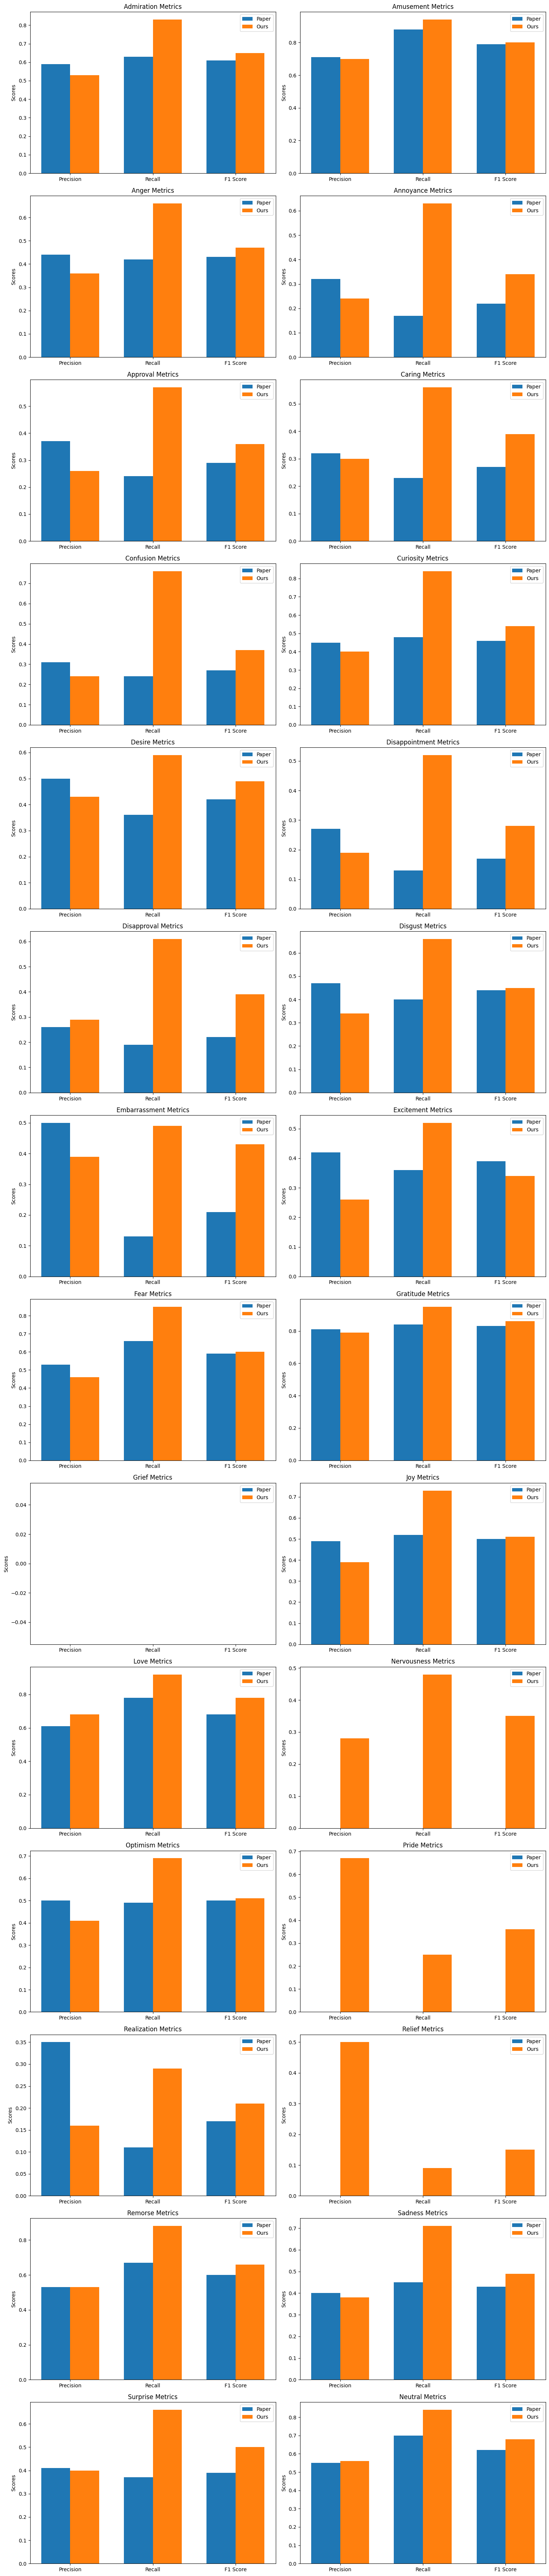

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the metrics for a set of emotions
def plot_metrics(emotions, paper_results, our_results, row_size=2):
    num_emotions = len(emotions)
    fig, axs = plt.subplots((num_emotions + row_size - 1) // row_size, row_size, figsize=(15, 5 * num_emotions // row_size))

    if axs.ndim == 1:
        axs = axs.reshape(-1, row_size)

    x = np.arange(3)  # for precision, recall, and F1 score
    width = 0.35  # bar width

    for i, emotion in enumerate(emotions):
        ax = axs[i // row_size, i % row_size]
        rects1 = ax.bar(x - width/2, paper_results[emotion], width, label='Paper')
        rects2 = ax.bar(x + width/2, our_results[emotion], width, label='Ours')

        ax.set_ylabel('Scores')
        ax.set_title(f'{emotion.capitalize()} Metrics')
        ax.set_xticks(x)
        ax.set_xticklabels(['Precision', 'Recall', 'F1 Score'])
        ax.legend()

    for i in range(num_emotions, row_size * axs.shape[0]):
        fig.delaxes(axs[i // row_size, i % row_size])

    fig.tight_layout()
    plt.show()


# Call the function to plot the metrics
plot_metrics(emotions, paper_results, our_results)